In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from shapely.geometry import Point, LineString, MultiPolygon, MultiLineString, shape
from descartes import PolygonPatch
import fiona

## 1. 读入路网文件

In [2]:
source = fiona.open("../data/chengdu_road.shp")

roads = [shape(geom["geometry"]) for geom in source]
roads = [geom for geom in roads if geom.geom_type=="LineString"]

In [3]:
network = MultiLineString(roads)

* 定义路网绘制函数

In [4]:
def draw_network(ax, roads, color_fun=lambda road: "r"):
    colors = [color_fun(road) for road in roads]
    segs = [road.coords for road in roads]
    line_segs = LineCollection(segs, colors=colors)
    ax.add_collection(line_segs)

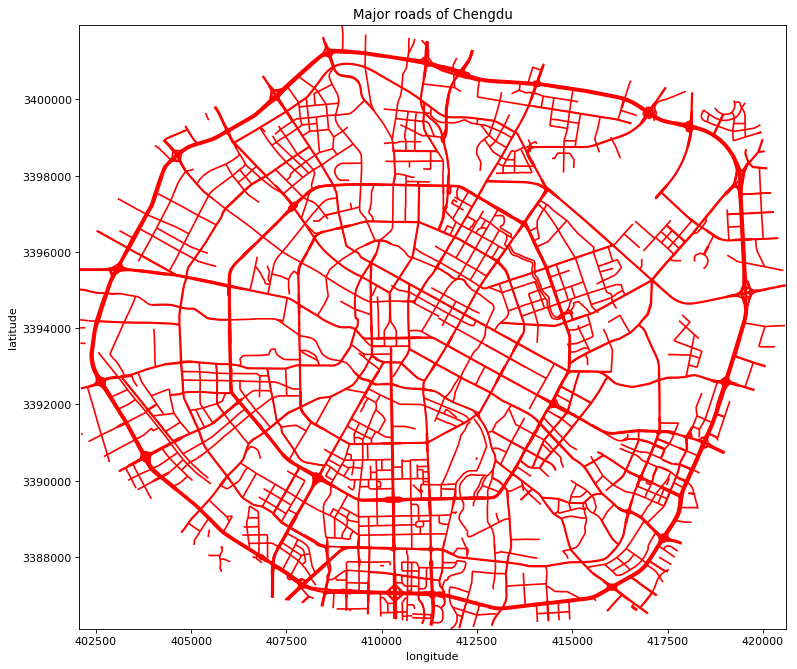

In [5]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Major roads of Chengdu")
draw_network(ax, roads)    
plt.savefig("chengdu_roads.png", dpi=150)
plt.show()

## 2. 正交对分
* 横向划分

In [6]:
def h_equal_divide(roads, weights=None):
    if weights is None:
        weights = [road.length for road in roads]
    else:
        weights = [weights[id(road)] for road in roads]
        
    network = MultiLineString(roads)
    minx, miny, maxx, maxy = network.bounds
    
    left = minx
    right = maxx
    
    while True:
        boundary = (left + right) / 2.0
        left_weight = 0.0
        right_weight = 0.0
        for road, weight in zip(roads, weights):
            if road.bounds[2] < boundary:
                left_weight += weight
            else:
                right_weight += weight

        if abs(left_weight-right_weight)/(left_weight+right_weight) < 0.5:
            break
            
        if abs(left-right)/(maxx-minx) <0.05:
            break
            
        if left_weight > right_weight:
            right = boundary
        else:
            left = boundary
    
    left_roads = []
    right_roads = []
    for road in roads:
        if road.bounds[2] < boundary:
            left_roads.append(road)
        else:
            right_roads.append(road)
            
    return left_roads, right_roads

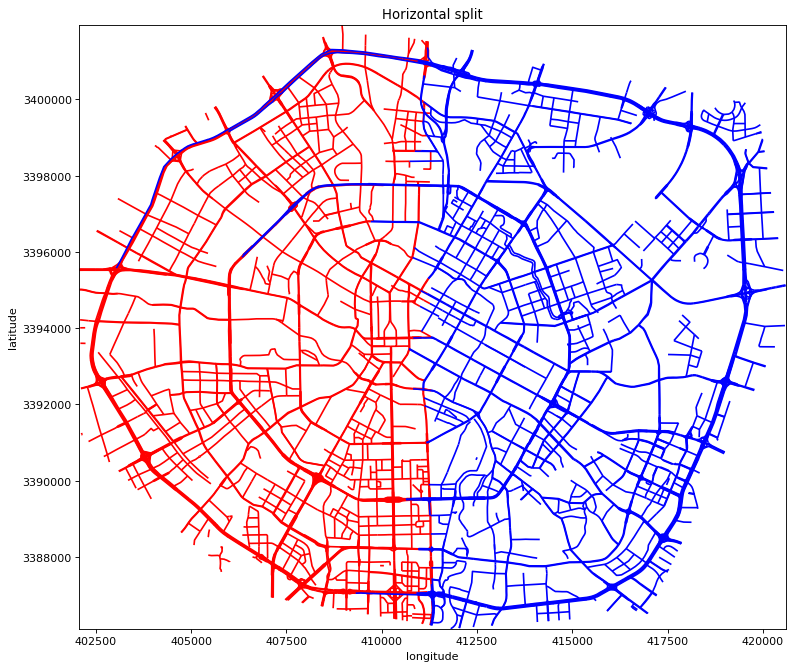

In [7]:
lr, rr = h_equal_divide(roads)

fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Horizontal split")
draw_network(ax, lr, lambda road:"r")    
draw_network(ax, rr, lambda road:"b")    
plt.show()

* 纵向划分

In [8]:
def v_equal_divide(roads, weights=None):
    if weights is None:
        weights = [road.length for road in roads]
    else:
        weights = [weights[id(road)] for road in roads]
        
    network = MultiLineString(roads)
    minx, miny, maxx, maxy = network.bounds
    
    bottom = miny
    top = maxy
    
    while True:
        boundary = (top + bottom) / 2.0
        top_weight = 0.0
        bottom_weight = 0.0
        for road, weight in zip(roads, weights):
            if road.bounds[3] < boundary:
                bottom_weight += weight
            else:
                top_weight += weight

        if abs(bottom_weight-top_weight)/(bottom_weight+top_weight) < 0.05:
            break
            
        if abs(bottom-top)/(maxy-miny) <0.05:
            break
            
        if bottom_weight > top_weight:
            top = boundary
        else:
            bottom = boundary
    
    bottom_roads = []
    top_roads = []
    for road in roads:
        if road.bounds[3] < boundary:
            bottom_roads.append(road)
        else:
            top_roads.append(road)
            
    return bottom_roads, top_roads

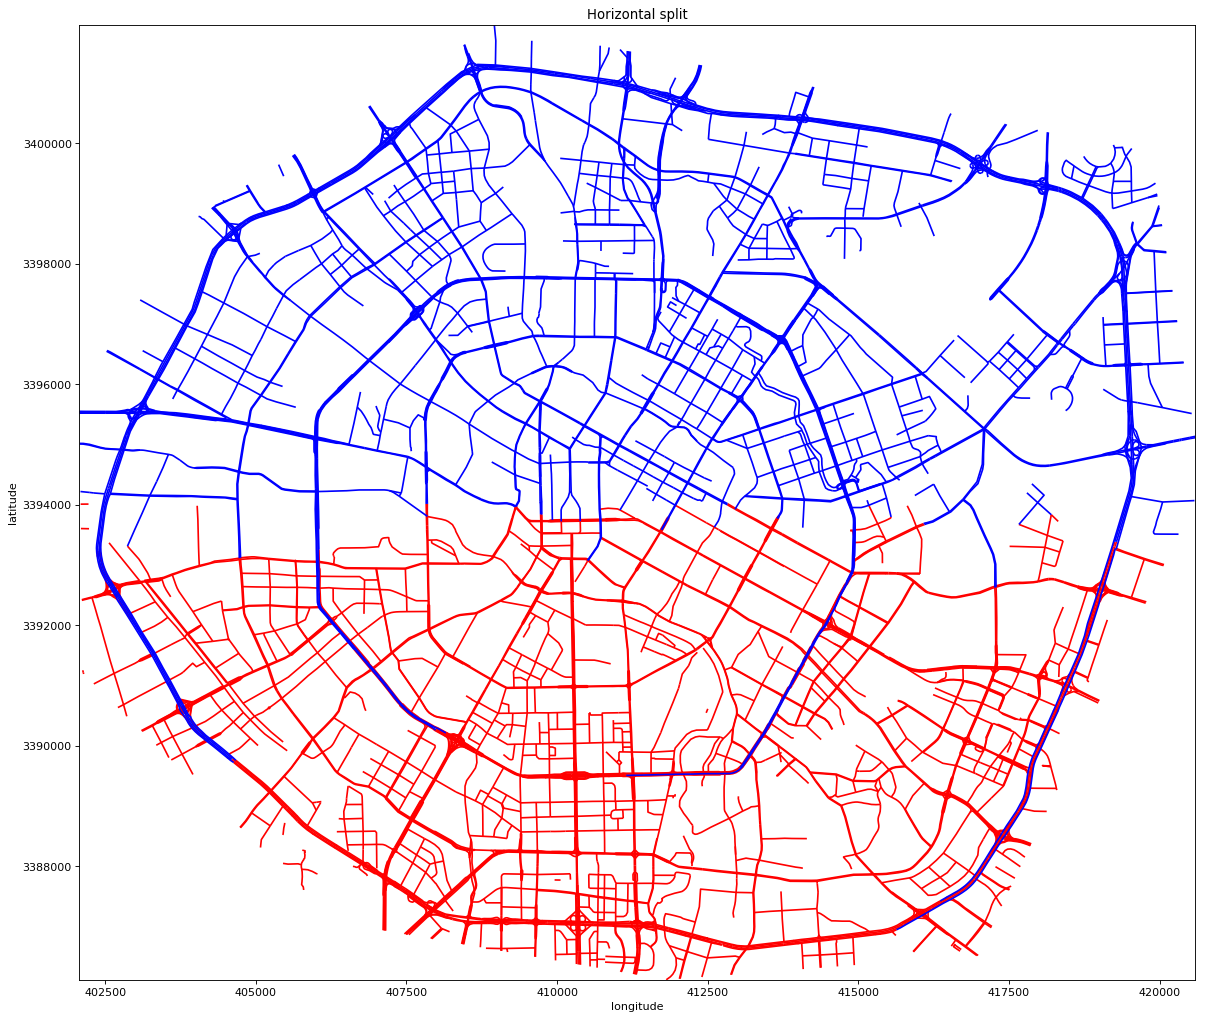

In [9]:
lr, rr = v_equal_divide(roads)

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Horizontal split")
draw_network(ax, lr, lambda road:"r")    
draw_network(ax, rr, lambda road:"b")    
plt.show()

* 递归划分

In [10]:
def recursive_divide(roads, level=3, weights=None):
    if weights is None:
        weights = {id(road):road.length for road in roads}
        
    if level == 1:
        return h_equal_divide(roads, weights)
    
    if level % 2:
        half_1, half_2 = h_equal_divide(roads, weights)
        parts_1 = recursive_divide(half_1, level-1, weights)
        parts_2 = recursive_divide(half_2, level-1, weights)
        return list(parts_1)+list(parts_2)
    else:
        half_1, half_2 = v_equal_divide(roads, weights)
        parts_1 = recursive_divide(half_1, level-1, weights)
        parts_2 = recursive_divide(half_2, level-1, weights)
        return list(parts_1)+list(parts_2)

In [11]:
areas = recursive_divide(roads, 4)

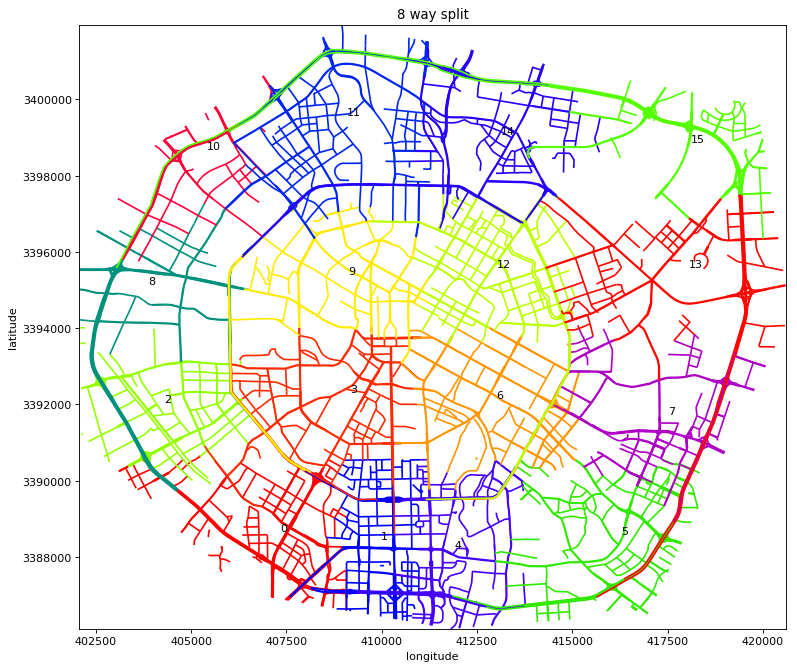

In [23]:
cmap = matplotlib.cm.get_cmap("prism")
colors = [cmap(i) for i in np.linspace(0, 1, 16)]

fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("8 way split")

for i, (area, color) in enumerate(zip(areas, colors)):
    draw_network(ax, area, lambda road:color)
    center_x = 0.0
    center_y = 0.0
    for road in area:
        minx, miny, maxx, maxy = road.bounds
        center_x += (minx + maxx)
        center_y += (miny + maxy)
    center_x /= (2*len(area))
    center_y /= (2*len(area))
        
    ax.text(center_x, center_y, str(i))

plt.show()

## 3. 权重生成

* 默认以路段长度为权重
* 给定分区，计算分区总权重

In [13]:
weights = {id(road):road.length for road in roads}

In [14]:
def area_weight(roads, weights):
    total = 0.0
    for road in roads:
        total += weights[id(road)]
    return total

In [15]:
area_weights = [area_weight(area, weights) for area in areas]

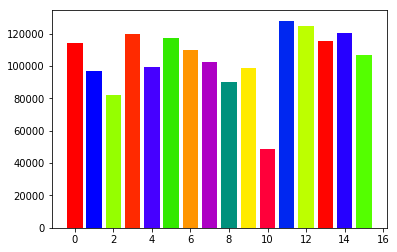

In [16]:
plt.bar(range(len(area_weights)), area_weights, color=colors);
plt.show()

* 按权重绘图

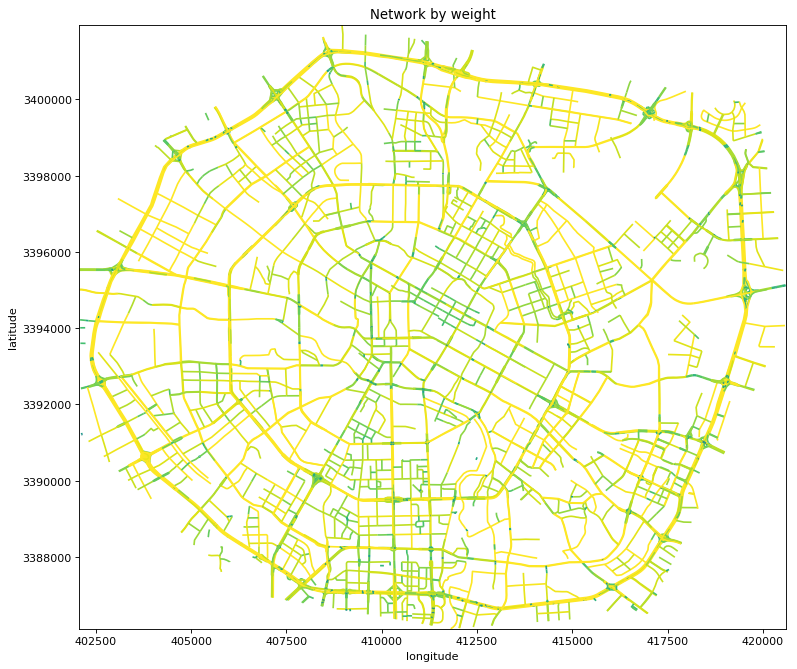

In [17]:
fig = plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = network.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect(1)

cmap = matplotlib.cm.get_cmap("viridis")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Network by weight")
draw_network(ax, roads, lambda road: cmap(np.log(road.length)/7))    
plt.show()

In [18]:
roads[100].centroid.y

3401184.9232597724